In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from pprint import pprint as pprint
from re import sub
from collections import namedtuple
from urllib2 import urlopen, Request, quote
from bs4 import BeautifulSoup
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from os.path import abspath
from random import randrange
from time import sleep
from itertools import chain

%matplotlib notebook

In [2]:
# url = "https://nethouseprices.com/house-prices/london?page=1"
# html = urlopen(url)
# soup = BeautifulSoup(html, "lxml")
# TO-DO: segment HTML downloading into chunks, and see if HTML can be saved to disk, and scraped by BeautifulSoup from disk.
# Also determine how much of the data to use as a dataset, and turn all your processing code into functions, so you can do
# this processing across multiple URLs to get one dataset you can model on.
# The next step is to do k-Means Clustering and get dummies, then run Random Forest Regressor, and write RESTful API.

In [3]:
# we download our entire dataset HTMLs in chunks, and write them to disk, only opening them when we need them.
def get_url_list(generic_url_string, start_page, end_page):
    return ["https://nethouseprices.com/house-prices/london?page={}".format(i) for i in xrange(start_page, end_page)]

def write_html_to_disk(url, generic_filepath, pageno):
#     print start, end
    delay = randrange(1,3)
    sleep(delay)
    f = urlopen(url)
    data = f.read()
#     filename = "{}_{}_raw.html".format(start, end)
    filename = generic_filepath.format(pageno)
    with open(filename, "w+") as html_file:
        html_file.write(data)
        print "Downloaded {} to {}".format(url, filename)

def write_multiple_html_to_disk_from_list(start, end, generic_filepath, url_list):
#     start_indices = list(xrange(start, end+1))
#     end_index_offset = chunk_size-1
#     # chooses a start index, and iterates through all urls in our sublist
#     [[write_html_to_disk(url, s+1, s+chunk_size) for url in url_list[s:s + chunk_size]] for s in start_indices]
    url_sublist = url_list[start:end]
    [write_html_to_disk(url, generic_filepath, pgnum) for url, pgnum in zip(url_sublist, xrange(start+1,end+1))]

    
url_list = get_url_list("https://nethouseprices.com/house-prices/london?page={}", 1, 12484)
write_multiple_html_to_disk_from_list(0, 10, "page{}_raw.html", url_list)

Downloaded https://nethouseprices.com/house-prices/london?page=1 to page1_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=2 to page2_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=3 to page3_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=4 to page4_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=5 to page5_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=6 to page6_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=7 to page7_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=8 to page8_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=9 to page9_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=10 to page10_raw.html


In [4]:
def read_html_from_disk(generic_filepath, pagenum):
    html_filepath = abspath(generic_filepath.format(i))
    html_from_file = urlopen("file:///{}".format(html_filepath)).read()
    return BeautifulSoup(html_from_file, 'lxml')

soup_kitchen = [read_html_from_disk("page{}_raw.html", i) for i in xrange(1,11)]
soup_kitchen

[<!DOCTYPE html>\n<!--[if lt IE 7]>\r\n<html lang="en-GB" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]--><!--[if IE 7]>\r\n<html lang="en-GB" class="no-js lt-ie9 lt-ie8"> <![endif]--><!--[if IE 8]>\r\n<html lang="en-GB" class="no-js lt-ie9"> <![endif]--><!--[if gt IE 8]><!--><html class="no-js" lang="en-GB"> <!--<![endif]-->\n<head>\n<title>Sold House Prices in London, Troubridge Square, | Nethouseprices.com</title>\n<meta content="text/html; charset=unicode-escape" http-equiv="Content-Type"/>\n<meta content="Free Sold House Prices in London, Troubridge Square,. Search the latest sold house prices for England and Wales provided under license from the Land Registry for free." name="description"/>\n<meta content="Sold Prices, Sold Prices London Troubridge Square, House Prices London Troubridge Square, House Prices, Free Sold House Prices, Property Prices, Sold House Prices, House Prices, Free Property Prices" name="keywords"/>\n<meta content="width=device-width, initial-scale=1" name="v

In [5]:
def multi_page_scrape(soup_list, tag, tag_class):
    return list(chain.from_iterable([soup.find_all(tag, class_=tag_class) for soup in soup_list]))

In [6]:
# Identified from element inspections via the Chrome developer console.
# addresses = soup.find_all("strong", class_="street-details-head-row")
# prices = soup.find_all("strong", class_="street-details-price-row")
# details = soup.find_all("div", class_="street-details-row")
addresses = multi_page_scrape(soup_kitchen, "strong", "street-details-head-row")
prices = multi_page_scrape(soup_kitchen, "strong", "street-details-price-row")
details = multi_page_scrape(soup_kitchen, "div", "street-details-row")
sale_dates_rows = multi_page_scrape(soup_kitchen, "tr", "sold_price_row")

# print len(addresses), len(prices), len(details), len(sale_dates_rows)

In [7]:
sale_date_strings = [i.findChildren('td')[-1].text for i in sale_dates_rows]
def parse_date(date_string):
    ds = date_string
    dsl = ds.split(" ")
    return " ".join(["".join([char if not char.isalpha() else "" for char in dsl[0]]), " ".join(dsl[1:])])

cleaned_sale_date_strings = [parse_date(i) for i in sale_date_strings]
# print cleaned_sale_date_strings
sale_dates = [datetime.strptime(i, "%d %B %Y") for i in cleaned_sale_date_strings]
# sale_dates

In [8]:
# Our scraped data series are set below.
addr = [i.find("a").string.replace(u"\xa0", " ") for i in addresses]
pxs = [float(i.string.replace(u"\xa3", "").replace(u",", "")) for i in prices]
property_characteristics = [[i.strip() for i in categories.string.split(",")] for categories in details]
# for i in property_characteristics:
#     if len(i) == 2:
#         print i
#  Some of our datapoints do not have flat type, so we must adapt for this.

flat_type = [i[0] if len(i) == 3 else np.nan for i in property_characteristics]
lease_type = [i[1] if len(i) == 3 else i[0] for i in property_characteristics]
build_status = [i[2] if len(i) == 3 else i[1] for i in property_characteristics]

In [9]:
print len(flat_type), len(lease_type), len(build_status)

500 500 500


In [10]:
geodata_urls = ["https://nominatim.openstreetmap.org/search?q=\"{}\"&format=json".format(i.replace(" ", "%20")) for i in addr]
    
def get_geodata_object(openstreetmap_api_url):
    url = openstreetmap_api_url
    json_response_text = BeautifulSoup(urlopen(url), "lxml").text
    return json.loads(json_response_text)

def convert_json_to_named_tuple(json_):
    """This is solely for our convenience when referencing JSON response attributes in dataset creation"""
    return json.loads(json_, object_hook=lambda dict_: namedtuple('X', dict_.keys())(*dict_.values()))

In [11]:
json_search_results = [get_geodata_object(url) for url in geodata_urls]
top_search_results = [result if len(result) == 0 else result[0] for result in json_search_results]
# for i in top_search_results:
#     pprint(i)

In [12]:
# We now convert these top search results back to JSON to make named tuples for ease of referencing in dataseries creation.
# top_search_results_as_strings = ['[{}]'.format(str(i)) if type(i) == dict else '{}'.format(i) for i in top_search_results]
top_search_results_as_json = [json.dumps(i).replace("class", "category").replace("type", "subcategory").replace("osm_subcategory", "osm_type") for i in top_search_results]
geodata_json = [convert_json_to_named_tuple(result) for result in top_search_results_as_json]

In [13]:
def load_geodata_attributes(geodata_obj):
    try:
        return (
                geodata_obj.category,
                geodata_obj.subcategory,
                float(geodata_obj.importance),
                float(geodata_obj.lon),
                float(geodata_obj.lat))
    except AttributeError: # this handles the case where our JSON loader did not find a JSON response from the API URL.
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

#TO-DO: add data parsed from display_name about borough as alternative to k Mean Clustering, to data frame.
# json_search_results = [get_geodata_object(url) for url in geodata_urls]
geodata = [load_geodata_attributes(result_named_tuple) for result_named_tuple in geodata_json]

category = [i[0] for i in geodata]
subcategory = [i[1] for i in geodata]
importance = [i[2] for i in geodata]
longitude = [i[3] for i in geodata]
latitude = [i[4] for i in geodata]

In [14]:
# We construct our dataset.
variables = [addr, pxs, sale_dates, flat_type, lease_type, build_status, category, subcategory, importance, longitude, latitude]
series_names = ["addresses",
                "prices",
                "sale_dates",
                "flat_type",
                "lease_type",
                "build_status",
                "category",
                "subcategory",
                "importance",
                "longitude",
                "latitude"]

# Check all series are the same length.
if len(pxs) == sum([len(dataseries) for dataseries in variables])/len(variables):
    # Setup dictionary for dataframe.
    dataset = {series_name : series for series_name, series in zip(series_names, variables)} 

In [15]:
# Beware some erroneous lon-lat data due to multiple search results and improper parsing of JSON response.
# NB: ignore the above, this was fixed. Now have to find a way of removing bad search data, say data 1SD away from mean lat lon.

dataset_frame = pd.DataFrame(dataset)
dataset_frame.head()

,addresses,build_status,category,flat_type,importance,latitude,lease_type,longitude,prices,sale_dates,subcategory
0,"Flat 14 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,517275.0,2018-09-26,NaN
1,"Flat 26 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,527175.0,2018-09-26,NaN
2,"91 Dames Road, London, E7 0DW",Non-Newbuild,highway,Terraced,0.61,51.553902,Freehold,0.023391,420000.0,2018-09-25,secondary
3,"82 Ramsay Road, London, E7 9EW",Non-Newbuild,highway,Terraced,0.51,51.556909,Freehold,0.017585,420000.0,2018-09-25,residential
4,"21 Mandela Street, London, SW9 6EL",Non-Newbuild,highway,Terraced,0.52,51.478533,Freehold,-0.110912,560000.0,2018-09-25,residential


In [16]:
# We add a new parameter, which we will use to exclude anomalous lat lon coordinates from bad Open Street Map API data.
    
dataset_frame["latitude_z_score"] = (dataset_frame.latitude - dataset_frame.latitude.mean()) / dataset_frame.latitude.std()
dataset_frame["longitude_z_score"] = (dataset_frame.longitude - dataset_frame.longitude.mean()) / dataset_frame.longitude.std()
dataset_frame.head()

,addresses,build_status,category,flat_type,importance,latitude,lease_type,longitude,prices,sale_dates,subcategory,latitude_z_score,longitude_z_score
0,"Flat 14 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,517275.0,2018-09-26,NaN,NaN,NaN
1,"Flat 26 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,527175.0,2018-09-26,NaN,NaN,NaN
2,"91 Dames Road, London, E7 0DW",Non-Newbuild,highway,Terraced,0.61,51.553902,Freehold,0.023391,420000.0,2018-09-25,secondary,0.208195,0.195103
3,"82 Ramsay Road, London, E7 9EW",Non-Newbuild,highway,Terraced,0.51,51.556909,Freehold,0.017585,420000.0,2018-09-25,residential,0.209921,0.194659
4,"21 Mandela Street, London, SW9 6EL",Non-Newbuild,highway,Terraced,0.52,51.478533,Freehold,-0.110912,560000.0,2018-09-25,residential,0.164931,0.184835


In [17]:
# We create new columns which introduce NaN data where the lat lon absolute Z scores exceed 3, indicating likely bad data.
# By bad data, we mean assuming a normal distribution, the lat lon coordinates are statistically significantly different
# from the average coordinates of all other datapoints. Given all the houses should be in London, this is a good filter.

dataset_frame["lat_z_score_mask"] = dataset_frame.latitude_z_score.where(dataset_frame.latitude_z_score.abs() < 3)
dataset_frame["lon_z_score_mask"] = dataset_frame.longitude_z_score.where(dataset_frame.longitude_z_score.abs() < 3)
dataset_frame.head()

,addresses,build_status,category,flat_type,importance,latitude,lease_type,longitude,prices,sale_dates,subcategory,latitude_z_score,longitude_z_score,lat_z_score_mask,lon_z_score_mask
0,"Flat 14 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,517275.0,2018-09-26,NaN,NaN,NaN,NaN,NaN
1,"Flat 26 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,527175.0,2018-09-26,NaN,NaN,NaN,NaN,NaN
2,"91 Dames Road, London, E7 0DW",Non-Newbuild,highway,Terraced,0.61,51.553902,Freehold,0.023391,420000.0,2018-09-25,secondary,0.208195,0.195103,0.208195,0.195103
3,"82 Ramsay Road, London, E7 9EW",Non-Newbuild,highway,Terraced,0.51,51.556909,Freehold,0.017585,420000.0,2018-09-25,residential,0.209921,0.194659,0.209921,0.194659
4,"21 Mandela Street, London, SW9 6EL",Non-Newbuild,highway,Terraced,0.52,51.478533,Freehold,-0.110912,560000.0,2018-09-25,residential,0.164931,0.184835,0.164931,0.184835


In [18]:
# We will also create dummy variables for all our non-numerical dataseries.
build_status_dummies = pd.get_dummies(dataset_frame.build_status)
flat_type_dummies = pd.get_dummies(dataset_frame.flat_type)
lease_type_dummies = pd.get_dummies(dataset_frame.lease_type)
category_dummies = pd.get_dummies(dataset_frame.category)
subcategory_dummies = pd.get_dummies(dataset_frame.subcategory)


dataframes_set = [dataset_frame, build_status_dummies, flat_type_dummies, lease_type_dummies, category_dummies, subcategory_dummies]
# for dataframe in dataframes_set:
#     dataframe.reset_index(drop=True)
    
dataset_frame = pd.concat(dataframes_set, axis=1)
# dataset_frame = pd.concat([dataset_frame, pd.get_dummies(dataset_frame.lease_type)], axis=1)
dataset_frame.head()

,addresses,build_status,category,flat_type,importance,latitude,lease_type,longitude,prices,sale_dates,...,pub,residential,restaurant,secondary,service,suburb,tertiary,trunk,uncategoryified,yes
0,"Flat 14 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,517275.0,2018-09-26,...,0,0,0,0,0,0,0,0,0,0
1,"Flat 26 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,527175.0,2018-09-26,...,0,0,0,0,0,0,0,0,0,0
2,"91 Dames Road, London, E7 0DW",Non-Newbuild,highway,Terraced,0.61,51.553902,Freehold,0.023391,420000.0,2018-09-25,...,0,0,0,1,0,0,0,0,0,0
3,"82 Ramsay Road, London, E7 9EW",Non-Newbuild,highway,Terraced,0.51,51.556909,Freehold,0.017585,420000.0,2018-09-25,...,0,1,0,0,0,0,0,0,0,0
4,"21 Mandela Street, London, SW9 6EL",Non-Newbuild,highway,Terraced,0.52,51.478533,Freehold,-0.110912,560000.0,2018-09-25,...,0,1,0,0,0,0,0,0,0,0


In [19]:
dataset_frame = dataset_frame.dropna()
cols_to_drop = ['build_status',
                'flat_type',
                'lease_type',
                'category',
                'subcategory',
                'latitude_z_score',
                'longitude_z_score',
                'lat_z_score_mask',
                'lon_z_score_mask']
final_dataset_frame = dataset_frame.drop(cols_to_drop, axis=1)
final_dataset_frame = final_dataset_frame.reset_index(drop=True)
final_dataset_frame.head()

,addresses,importance,latitude,longitude,prices,sale_dates,Newbuild,Non-Newbuild,Detached,Flat,...,pub,residential,restaurant,secondary,service,suburb,tertiary,trunk,uncategoryified,yes
0,"91 Dames Road, London, E7 0DW",0.61,51.553902,0.023391,420000.0,2018-09-25,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,"82 Ramsay Road, London, E7 9EW",0.51,51.556909,0.017585,420000.0,2018-09-25,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,"21 Mandela Street, London, SW9 6EL",0.52,51.478533,-0.110912,560000.0,2018-09-25,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,"115 Murray Road, London, W5 4DB",0.51,51.493612,-0.313211,495000.0,2018-09-24,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,"55 Briar Avenue, London, SW16 3AB",0.61,51.417612,-0.119799,535000.0,2018-09-24,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [20]:
# We will save our dataset frame just in case, as a csv and json document.
final_dataset_frame.to_csv("final_dataset_frame.csv")
final_dataset_frame.to_json("final_dataset_frame.json")

In [21]:
# We will now plot our latitude and longitude coordinates to get a sense of how many clusters we may have geographically.
fdf = final_dataset_frame

x = fdf.longitude
y = fdf.latitude
z = fdf.prices

<IPython.core.display.Javascript object>


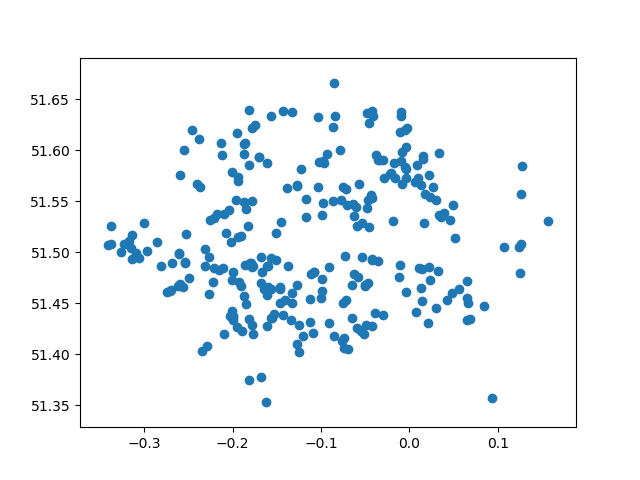

In [22]:
fig0 = plt.figure()
scat = plt.scatter(x, y)
plt.show()

<IPython.core.display.Javascript object>


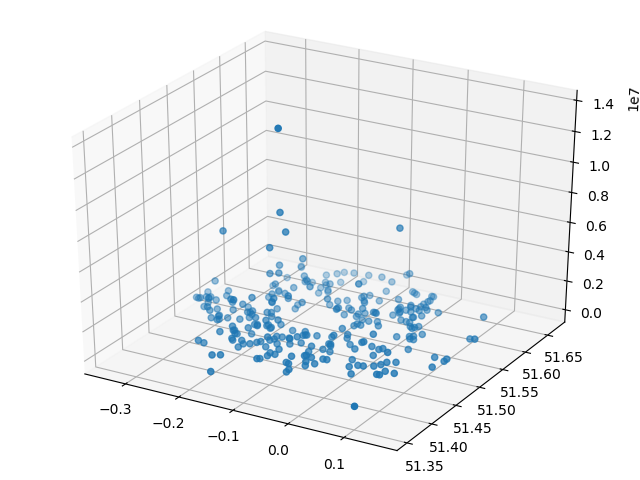

In [23]:
fig1 = plt.figure()
ax = Axes3D(fig1)

ax.scatter(x, y, z)